# Exploring Co-Morbidities

## Read data files

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240531/data/data_matrix.csv')
icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')

/tmp/ipykernel_15508/3040462972.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')


In [2]:
icdDf.shape, datamatrixDf.shape

((456648, 7), (116754, 194))

## Filter patients from the cohort

In [3]:
filteredIcdDf = icdDf.merge(
    datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates(),
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
    )

In [4]:
filteredIcdDf.shape

(62563, 9)

## Explore

In [5]:
datamatrixDf.person_id.drop_duplicates().shape[0]

3951

In [6]:
filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]

1743

In [7]:
filteredIcdDf.shape[0]

62563

In [8]:
filteredIcdDf.shape[0]/filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]

35.8938611589214

In [9]:
filteredIcdDf

,EPISODE_ID,PATIENT_ID,AUSTRALIAN_MODIFICATION,PREFIX,ICD_DESCRIPTION,RANK,ICD10CODE,person_id,visit_occurrence_id
0,17101855,2182523,Z029,P,"Examination for administrative purposes, unspe...",1,NaN,2182523,17101855
1,17080890,111862,C9100,P,"Acute lymphoblastic leukaemia [ALL], without m...",1,C91.0,111862,17080890
2,17080890,111862,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,111862,17080890
3,17079063,2402765,Z029,P,"Examination for administrative purposes, unspe...",1,NaN,2402765,17079063
4,17042321,2480594,R040,C,Epistaxis,6,NaN,2480594,17042321
...,...,...,...,...,...,...,...,...,...
62558,133225,2152832,C9101,P,"Acute lymphoblastic leukaemia [ALL], in remission",1,NaN,2152832,133225
62559,133225,2152832,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,2152832,133225
62560,113016,2152832,Z511,P,Pharmacotherapy session for neoplasm,1,NaN,2152832,113016
62561,113016,2152832,C9100,P,"Acute lymphoblastic leukaemia [ALL], without m...",2,NaN,2152832,113016


### Word Cloud

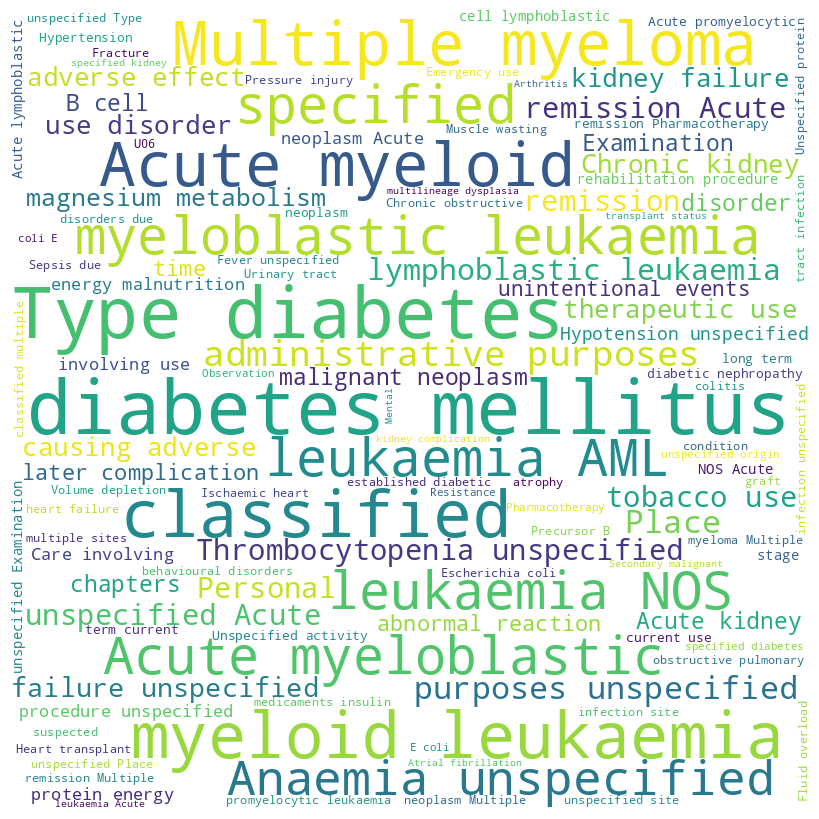

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

stopwords = set(STOPWORDS)
additionalStopwords = {'facility', 'service', 'area', 'session', 'cause', 'occurrence', 'faculty', 'diseases', 'disease', 'health', 'without', 'elsewhere', 'history', 'mention'}
stopwords = stopwords.union(additionalStopwords)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(filteredIcdDf.ICD_DESCRIPTION))

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Counts

#### Episode level

In [11]:
episodeCountsDf = filteredIcdDf[['EPISODE_ID', 'PATIENT_ID', 'ICD_DESCRIPTION']]\
    .groupby(['EPISODE_ID', 'PATIENT_ID']).agg(['count'])
episodeCountsDf.columns = episodeCountsDf.columns.droplevel(0)
episodeCountsDf = episodeCountsDf.reset_index()
episodeCountsDf

,EPISODE_ID,PATIENT_ID,count
0,113016,2152832,3
1,133225,2152832,2
2,145028,1548773,6
3,178895,2081586,2
4,189928,2152832,3
...,...,...,...
9049,17020273,2225820,4
9050,17042321,2480594,6
9051,17079063,2402765,1
9052,17080890,111862,2


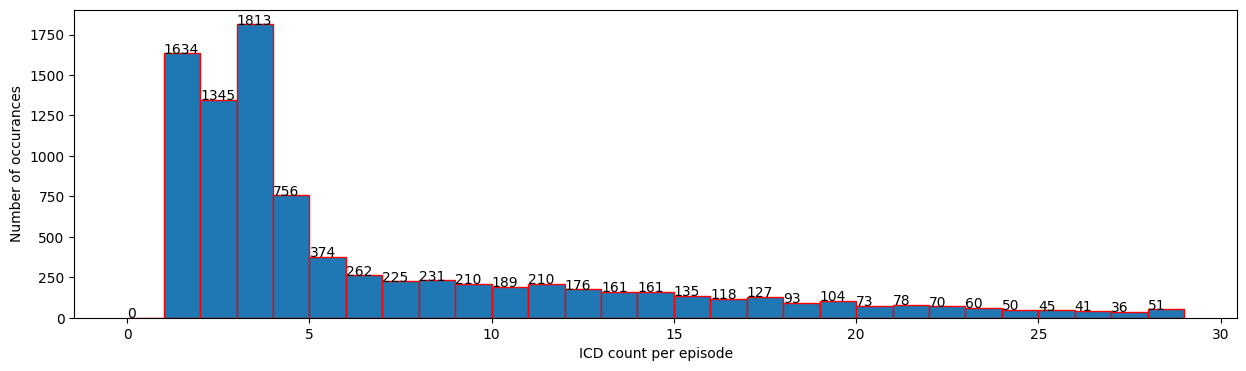

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histogram of the data
bins = np.arange(0,30,1)
fig = plt.figure(figsize=(15,4))
ax = plt.gca()
counts, _, patches = ax.hist(episodeCountsDf['count'], bins=bins, edgecolor='r')
for count, patch in zip(counts,patches):
    ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
plt.xlabel('ICD count per episode')
plt.ylabel('Number of occurances')
plt.show()


#### Person Level

In [13]:
personCountsDf = filteredIcdDf[['PATIENT_ID', 'ICD_DESCRIPTION']]\
    .groupby(['PATIENT_ID']).agg(['count'])
personCountsDf.columns = personCountsDf.columns.droplevel(0)
personCountsDf = personCountsDf.reset_index()
personCountsDf

,PATIENT_ID,count
0,50056,19
1,56749,30
2,57756,25
3,62567,12
4,77432,8
...,...,...
1738,2513125,25
1739,2514472,31
1740,2515515,175
1741,2522101,12


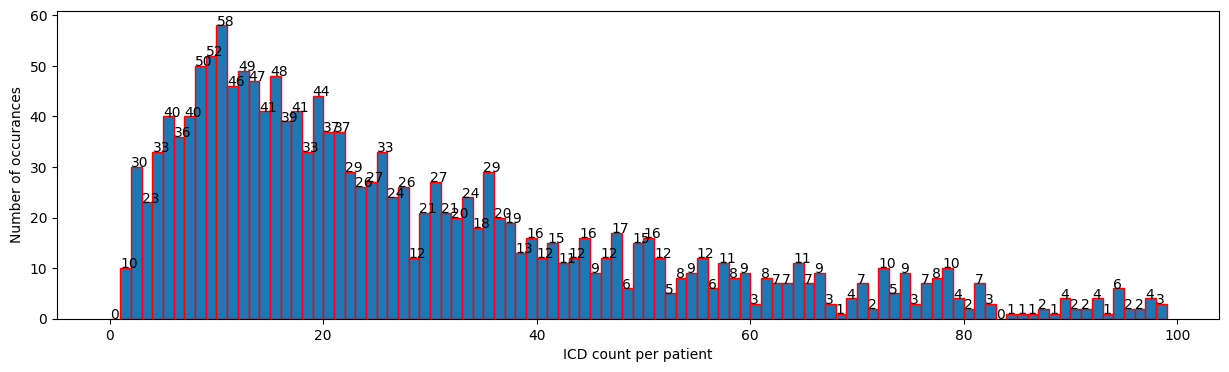

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histogram of the data
bins = np.arange(0,100,1)
fig = plt.figure(figsize=(15,4))
ax = plt.gca()
counts, _, patches = ax.hist(personCountsDf['count'], bins=bins, edgecolor='r')
for count, patch in zip(counts,patches):
    ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
plt.xlabel('ICD count per patient')
plt.ylabel('Number of occurances')
plt.show()


### Top co-morbidities

In [22]:
topComorbiditiesDf = filteredIcdDf[['ICD_DESCRIPTION', 'PATIENT_ID']].groupby(['ICD_DESCRIPTION']).agg(['count'])
topComorbiditiesDf.columns = topComorbiditiesDf.columns.droplevel(0)
topComorbiditiesDf = topComorbiditiesDf.reset_index()
pd.set_option('display.max_colwidth', None)
topComorbiditiesDf.sort_values(by=['count'], ascending=False)[:20]

,ICD_DESCRIPTION,count
2421,Pharmacotherapy session for neoplasm,1681
864,"Examination for administrative purposes, unspecified",1354
1201,Hypertension,1311
2450,"Place of occurrence, health service area, this facility",1209
106,Acute myeloid leukaemia NOS,1188
200,"Anaemia, unspecified",1152
2973,"Thrombocytopenia, unspecified",1010
1675,Multiple myeloma,956
105,"Acute myeloblastic leukaemia [AML], without mention of remission",933
1677,"Multiple myeloma, without mention of remission",901


In [38]:
filteredIcdDf['ICD_CATEGORY'] = filteredIcdDf.AUSTRALIAN_MODIFICATION.str[:3]
topIcdCategoriesDf = filteredIcdDf[['ICD_CATEGORY', 'PATIENT_ID']].drop_duplicates().groupby(by=['ICD_CATEGORY']).agg(['count'])
topIcdCategoriesDf.columns = topIcdCategoriesDf.columns.levels[1]
topIcdCategoriesDf = topIcdCategoriesDf.reset_index()
topIcdCategoriesDf['ratio'] = round(topIcdCategoriesDf['count']/filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]*100, 2)
topIcdCategoriesDf = topIcdCategoriesDf.sort_values(by=['count'], ascending=False)
topIcdCategoriesDf[:20]

,ICD_CATEGORY,count,ratio
982,Y92,1061,60.87
869,U82,794,45.55
190,E87,766,43.95
613,N17,573,32.87
11,A41,526,30.18
132,D64,523,30.01
388,I95,511,29.32
1028,Z86,484,27.77
865,U73,467,26.79
186,E83,464,26.62


In [30]:
icdCategoriesData = [
    ['Y92', 'Place of occurrence of the external cause'],
    ['U82', 'Resistance to betalactam antibiotics'],
    ['E87', 'Other disorders of fluid, electrolyte and acid-base balance'],
    ['N17', 'Acute renal failure'],
    ['A41', 'Other sepsis'],
    ['D64', 'Anaemia'],
    ['I95', 'Hypotension'],
    ['Z86', 'Personal history of certain other diseases'],
    ['U73', 'Unspecified activity'],
    ['E83', 'Disorders of mineral metabolism'],
    ['E11', 'Type 2 diabetes mellitus'],
    ['B96', 'Bacterial agents as the cause of diseases classified to other chapters'],
    ['Z50', 'Rehabilitation'],
    ['Z51', 'Encounter for other aftercare and medical care'],
    ['N39', 'Disorders of urinary system'],
]
icdCategoriesDf = pd.DataFrame(icdCategoriesData, columns=['ICD_CATEGORY', 'DESCRIPTION'])
icdCategoriesDf

,ICD_CATEGORY,DESCRIPTION
0,Y92,Place of occurrence of the external cause
1,U82,Resistance to betalactam antibiotics
2,E87,"Other disorders of fluid, electrolyte and acid-base balance"
3,N17,Acute renal failure
4,A41,Other sepsis
5,D64,Anaemia
6,I95,Hypotension
7,Z86,Personal history of certain other diseases
8,U73,Unspecified activity
9,E83,Disorders of mineral metabolism


In [42]:
topIcdCategoriesDf[:20].merge(icdCategoriesDf, on=['ICD_CATEGORY'], how='inner')

,ICD_CATEGORY,count,ratio,DESCRIPTION
0,Y92,1061,60.87,Place of occurrence of the external cause
1,U82,794,45.55,Resistance to betalactam antibiotics
2,E87,766,43.95,"Other disorders of fluid, electrolyte and acid-base balance"
3,N17,573,32.87,Acute renal failure
4,A41,526,30.18,Other sepsis
5,D64,523,30.01,Anaemia
6,I95,511,29.32,Hypotension
7,Z86,484,27.77,Personal history of certain other diseases
8,U73,467,26.79,Unspecified activity
9,E83,464,26.62,Disorders of mineral metabolism
